In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score

from sklearn.linear_model import SGDRegressor

from sklearn.svm import SVR

from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cb
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

Корректируем датасет:  
1) корректировка используемого в модели значения капитализации и разницы логарифмов между раундами  
2) исключение раундов "без ответа"  
3) приведение дат к нужному формату

In [2]:
nan = [np.nan]
default_exit_value = 1 #"капитализация" мертвой компании в долларах

In [3]:
dataset = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/valuation_prediction/1_DataPreparation/funding_rounds_with_exits.csv')
dataset['raised_amount_usd'] = pd.to_numeric(dataset['raised_amount_usd'], errors='coerce')
dataset.loc[dataset['raised_amount_usd'].isin(nan), 'raised_amount_usd'] = 0
dataset['post_money_valuation_usd'] = pd.to_numeric(dataset['post_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['post_money_valuation_usd'].isin(nan), 'post_money_valuation_usd'] = 0

dataset['total_sum_raised'] = dataset.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
dataset['total_sum_raised_before'] = dataset.groupby('company_uuid')['total_sum_raised'].shift(1)
dataset.loc[dataset['total_sum_raised_before'].isin(nan), 'total_sum_raised_before'] = 0

dataset = dataset.loc[(dataset['post_money_valuation_usd'] != 0) & (dataset['raised_amount_usd'] != 0)]
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,total_sum_raised,total_sum_raised_before
18,e51334dc-6f05-4d37-98f0-27b6914c0564,HeartFlow,0074c110-5dd9-4af1-29a7-cecd2ae1b86c,series_e,2018-02-14,240000000.0,1.500000e+09,3331.0,2858.0,761.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,466646417.0,226646417.0
25,1df8734f-be0d-282d-e099-91be92e85554,Udacity,00d85dac-7a9d-ed45-7f53-1bcac9c7b6f9,series_d,2015-11-11,105000000.0,1.000000e+09,2505.0,1410.0,413.0,1.0,1.0,4.0,7.0,10.0,8.0,4.0,3.0,160000000.0,55000000.0
39,dc86e493-6cee-9eb3-e558-c66b91f527c3,Sentient Technologies,0104b004-f68f-b66d-1d6b-10e4ff8dec57,series_c,2014-11-24,103600000.0,7.001000e+08,2153.0,2104.0,278.0,1.0,1.0,1.0,11.0,2.0,12.0,2.0,4.0,145380450.0,41780450.0
40,01f5449f-0ea2-4d4e-bc49-1fe5aac9412f,Sentient Technologies,0104b004-f68f-b66d-1d6b-10e4ff8dec57,series_d,2017-06-30,29000000.0,1.450000e+08,3102.0,3053.0,949.0,0.0,1.0,1.0,11.0,2.0,12.0,2.0,4.0,174380450.0,145380450.0
70,d398249a-9fa1-55d3-1edb-bb1bb1873850,ALPHAEON Corporation,01816c87-1fcb-c823-75ab-c67735887aad,series_a,2015-01-16,27000015.0,5.270000e+08,2206.0,4.0,4.0,1.0,0.0,1.0,3.0,3.0,3.0,3.0,1.0,27000015.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,8e0b0271-f9f7-12dd-af98-e3dab9c782eb,Essential,fe04b327-09e6-1a5c-6d11-aa40fa54367c,series_b,2017-06-07,300000000.0,9.930000e+08,3079.0,482.0,482.0,1.0,1.0,2.0,5.0,3.0,5.0,2.0,2.0,330000000.0,30000000.0
15349,f619ba6f-6451-5184-98a4-bf17cabe49e7,Lendio,ff766527-8bc1-a5c1-c89d-a4595cb5f147,series_c,2015-03-24,22000000.0,5.200000e+07,2273.0,1496.0,573.0,1.0,1.0,6.0,5.0,13.0,8.0,4.0,4.0,32500000.0,10500000.0
15350,39a988f6-cb5b-09d9-78a7-a7b100bff06a,Lendio,ff766527-8bc1-a5c1-c89d-a4595cb5f147,series_d,2016-10-25,19000000.0,9.400000e+07,2854.0,2077.0,581.0,1.0,1.0,6.0,5.0,13.0,8.0,4.0,4.0,51500000.0,32500000.0
15362,db46bd0b-baad-408d-adbc-e4511feebaf9,LimeBike,ff9936d8-4d83-cb80-0196-809aa51a0e41,series_b,2017-10-16,50000000.0,2.250000e+08,3210.0,215.0,215.0,1.0,1.0,6.0,13.0,8.0,13.0,3.0,4.0,62000000.0,12000000.0


### Preprocessing

Создаем выборки

In [4]:
dataset.columns

Index(['funding_round_uuid', 'company_name', 'company_uuid', 'investment_type',
       'announced_on', 'raised_amount_usd', 'post_money_valuation_usd',
       'time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor', 'other_investor', 'top_investor_count',
       'other_investor_count', 'top_investor_sum', 'other_investor_sum',
       'top_investor_rounds', 'other_investor_rounds', 'total_sum_raised',
       'total_sum_raised_before'],
      dtype='object')

In [5]:
y = dataset[['post_money_valuation_usd']]
X = dataset.drop(columns=['funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'post_money_valuation_usd', 'total_sum_raised', 'top_investor', 'other_investor'])

X = X[['raised_amount_usd',
       'time_from_2009',
       'time_from_start',
       'time_from_previous',
       'total_sum_raised_before',
       'top_investor_rounds',
       'other_investor_rounds'
      ]]

In [6]:
# X_send = X.copy()
# X_send.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
# X_send.to_csv('X_send_w2.csv', encoding = 'utf-8-sig')
# X_send

In [7]:
# y_send = y.copy()
# y_send.columns = ['answer']
# y_send.to_csv('y_send_w2.csv', encoding = 'utf-8-sig')
# y_send

In [8]:
features = X.columns
features

Index(['raised_amount_usd', 'time_from_2009', 'time_from_start',
       'time_from_previous', 'total_sum_raised_before', 'top_investor_rounds',
       'other_investor_rounds'],
      dtype='object')

In [9]:
X = X.values.astype(np.float) #X = X.to_numpy(dtype=np.float)
print(X.shape)

(717, 7)


In [10]:
y = y.values.ravel() #y = y.to_numpy()
print(y.shape)

(717,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_test_t = skaler.transform(X_test)

In [12]:
# wave1_acc = []
# wave1_PR = []
# wave1_RC = []
# wave1_features = []

### Sklearn SGDRegressor

In [15]:
param_grid = {
    'loss': ['squared_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling']
}

estimator = SGDRegressor()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1)
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

{'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'l1'}

In [18]:
# acc_array = []
# f1_array = []
# PR_array = []
# RC_array = []
# feature_array = []
best_grid1 = grid_search.best_estimator_
best_grid1.fit(X_train_t, y_train)
predicted_labels = best_grid1.predict(X_test_t)
#best_grid1.score(y_test, predicted_labels)

In [19]:
y_test

array([3.75000000e+07, 1.40000000e+09, 1.23000000e+08, 1.04000000e+08,
       7.30000000e+07, 2.46000000e+10, 1.00000000e+09, 1.00000000e+09,
       3.50050000e+08, 1.95599970e+07, 3.45000000e+08, 2.50000000e+09,
       7.00000000e+08, 2.54000000e+08, 4.20000000e+09, 1.07900000e+08,
       7.50000000e+07, 7.00000000e+08, 5.20000000e+07, 1.10000000e+08,
       6.00000000e+08, 4.35000000e+09, 3.05000000e+08, 1.26000000e+08,
       2.30000000e+09, 2.50000000e+09, 2.28000000e+08, 4.12000000e+10,
       7.00000000e+08, 2.17500000e+08, 1.74510000e+08, 1.09000000e+09,
       7.00000000e+08, 1.50000000e+09, 3.20000000e+08, 2.40000000e+08,
       6.20000000e+08, 2.00000000e+08, 7.00000000e+08, 1.65000000e+09,
       7.50000000e+09, 7.00000000e+08, 1.02000000e+08, 4.25000000e+08,
       6.00000000e+08, 1.00000000e+08, 2.50000000e+08, 1.50000000e+08,
       1.43000000e+08, 1.60000000e+09, 7.49600000e+08, 5.30000000e+08,
       3.00000000e+09, 1.00000000e+09, 1.76000000e+08, 1.15000000e+08,
      

In [20]:
predicted_labels

array([-1.05939752e+07,  5.64649678e+09, -2.71538446e+08,  6.83334192e+07,
        2.12077471e+09,  1.87377868e+10,  1.42549508e+09,  9.30039091e+08,
        3.70285485e+08, -7.69759268e+08,  6.22202072e+08,  1.44536006e+10,
        1.68741239e+09,  2.73991082e+09,  6.42282324e+09, -2.93764583e+08,
        4.32164534e+07,  8.98047610e+08, -2.85003168e+08, -6.26952187e+08,
        1.77025991e+09,  7.44083815e+09, -3.00629100e+08, -2.98847126e+08,
        4.81914587e+09,  7.49906072e+09,  1.26530885e+09,  2.46139903e+10,
        4.52362151e+08,  4.09960856e+08, -7.94936445e+07,  1.33225489e+09,
        1.02598542e+09,  2.64194158e+09, -1.87346045e+08,  6.06798819e+08,
        6.99540033e+08, -2.28748021e+08,  7.62905237e+08,  3.33926532e+07,
        2.07401271e+10,  2.08956255e+08, -6.03640617e+08, -3.25385346e+07,
        4.33378858e+08, -1.96867882e+08,  6.77170520e+08, -4.20994524e+08,
       -4.29462088e+08,  2.55010578e+08,  2.49097674e+09,  6.73075285e+08,
        4.75087719e+09,  

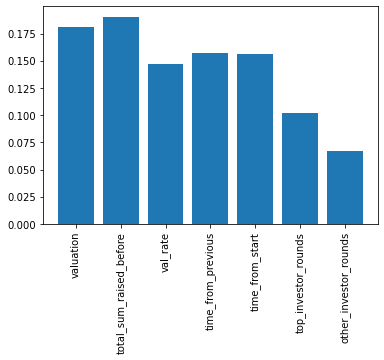

In [32]:
plt.bar(range(len(features)), best_grid1.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [33]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### Sklearn Gradient Boosting

In [34]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [20, 50, 60, 70, 80, 90, 100, 110]
}

estimator = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


{'learning_rate': 0.3,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 80}

In [35]:
acc_array = []
f1_array = []
PR_array = []
RC_array = []
feature_array = []
best_grid2 = grid_search.best_estimator_
for j in range(10):
    best_grid2.fit(X_train_t, y_train)
    predicted_labels = best_grid2.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid2.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.6235897435897435
f1 = 0.6131067567600959


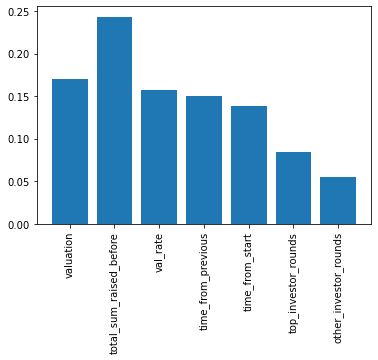

In [36]:
plt.bar(range(len(features)), best_grid2.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [37]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### XGBoost

In [38]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

estimator = XGBClassifier(objective="binary:logistic")
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring="accuracy") #verbose = 2, scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

[15:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Barca\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 5,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [39]:
grid_search.best_score_

0.6688397188397189

In [40]:
# best_grid3 = grid_search.best_estimator_
best_grid3 = XGBClassifier(objective="binary:logistic", **grid_search.best_params_)
best_grid3.fit(X_train_t, y_train)

[15:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
predicted_labels = best_grid3.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')
PR = precision_score(y_test, predicted_labels, average = 'macro')
RC = recall_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'PR = {PR}')
print(f'RC = {RC}')
print(f'f1 = {f1}')

acc = 0.6461538461538462
f1 = 0.6306108442004118


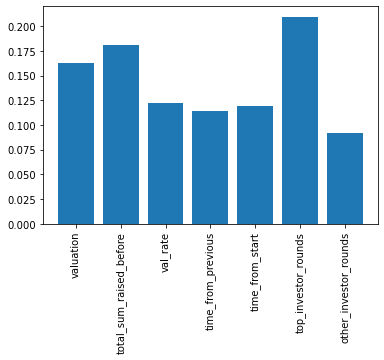

In [42]:
plt.bar(range(len(features)), best_grid3.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [43]:
wave1_acc.append(acc)
wave1_PR.append(PR)
wave1_RC.append(RC)
wave1_features.append(best_grid3.feature_importances_)

In [44]:
wave1_acc

[0.6430769230769231, 0.6235897435897435, 0.6461538461538462]

In [ ]:
wave1_PR

In [ ]:
wave1_RC

In [45]:
wave1_features

[array([0.17204931, 0.2114819 , 0.14504606, 0.15061011, 0.14732585,
        0.10633672, 0.06715005]),
 array([0.16960739, 0.24497566, 0.16779687, 0.14501594, 0.12826459,
        0.08828855, 0.05605101]),
 array([0.16286115, 0.180712  , 0.12181314, 0.11438428, 0.11911802,
        0.20934844, 0.09176298], dtype=float32)]

In [46]:
wave1real_df = pd.DataFrame(list(zip([wave1_acc[0]], [wave1_acc[1]], [wave1_acc[2]])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
wave1realf_df = pd.DataFrame(list(zip(wave1_features[0], wave1_features[1], wave1_features[2])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
features = features.insert(0, 'ACCURACY')
parameters = pd.DataFrame(list(features), columns =['Parameter'])
wave1real_df = wave1real_df.append(wave1realf_df).reset_index(drop=True)
wave1real_df = pd.concat([parameters, wave1real_df], axis=1)
wave1real_df.to_csv('wave2_results.csv', encoding = 'utf-8-sig')
wave1real_df

,Parameter,Random Forest,Gradient Boosting,XGBoost Classifier
0,ACCURACY,0.643077,0.623590,0.646154
1,valuation,0.172049,0.169607,0.162861
2,total_sum_raised_before,0.211482,0.244976,0.180712
3,val_rate,0.145046,0.167797,0.121813
4,time_from_previous,0.150610,0.145016,0.114384
5,time_from_start,0.147326,0.128265,0.119118
6,top_investor_rounds,0.106337,0.088289,0.209348
7,other_investor_rounds,0.067150,0.056051,0.091763


In [47]:
predicted_labels1 = best_grid1.predict(X_DEMO_t)
predicted_labels2 = best_grid2.predict(X_DEMO_t)
predicted_labels3 = best_grid3.predict(X_DEMO_t)

In [63]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET[['company_name']].reset_index(drop=True), a, b, c], axis=1)
demo.to_csv('forecast_w2.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,Roblox Corporation,0.0,0.0,1.0
1,Lemonade,1.0,1.0,1.0
2,Palantir Technologies,1.0,0.0,1.0
3,DoorDash,1.0,1.0,1.0
4,JFrog,0.0,0.0,1.0
5,Unity Technologies,1.0,1.0,1.0
6,Sumo Logic,1.0,1.0,1.0
7,Snowflake Computing,1.0,1.0,1.0
8,Airbnb,1.0,1.0,1.0
9,Asana,1.0,1.0,1.0


### На единичных признаках

In [33]:
y = dataset[['not_dead']]
y = y.values.ravel()
X_general = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])

skaler = StandardScaler()
param_grid = {
    'bootstrap': [True, False], #rf only
#    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #boosting only
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}
estimator = RandomForestClassifier() #0.65-0.71
#estimator = GradientBoostingClassifier() #0.6-0.66
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')

X_general.columns

Index(['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'total_sum_raised_before', 'valuation', 'log_rate'],
      dtype='object')

In [34]:
mean_acc = []
mean_f1 = []
features = ['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'total_sum_raised_before', 'valuation', 'val_rate']
for i in features:
    X = X_general[[i]]
    X = X.values.astype(np.float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_t = skaler.fit_transform(X_train)
    X_test_t = skaler.transform(X_test)
    grid_search.fit(X_train_t, y_train)
    best_grid = grid_search.best_estimator_
    
    acc_array = []
    f1_array = []
    PR_array = []
    RC_array = []
    for j in range(10):
        best_grid.fit(X_train_t, y_train)
        predicted_labels = best_grid.predict(X_test_t)
        acc = accuracy_score(y_test, predicted_labels)
        f1 = f1_score(y_test, predicted_labels, average = 'macro')
        PR = precision_score(y_test, predicted_labels, average = 'macro')
        RC = recall_score(y_test, predicted_labels, average = 'macro')
        acc_array.append(acc)
        PR_array.append(PR)
        RC_array.append(RC)
        f1_array.append(f1)
    mean_acc.append(np.mean(acc_array))
    mean_f1.append(np.mean(f1_array))
    #print(f'acc on {i} = {np.mean(acc_array)}')
    #print(f'f1 on {i} = {np.mean(f1_array)}')
mean_acc_f1_df = pd.DataFrame(list(zip(mean_acc, mean_f1)), 
               columns =['Accuracy', 'F-Score']).set_index([features])
print(mean_acc_f1_df)

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 3620 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   50.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   50.3s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   48.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.3s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.5s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.7s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.3s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   45.2s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   41.8s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   52.9s finished


                         Accuracy   F-Score
time_from_2009           0.561538  0.557030
time_from_start          0.503077  0.496843
time_from_previous       0.518462  0.507093
top_investor_count       0.620513  0.615159
other_investor_count     0.584103  0.549638
top_investor_sum         0.548718  0.546877
other_investor_sum       0.527692  0.507549
top_investor_rounds      0.579487  0.526923
other_investor_rounds    0.602051  0.559214
total_sum_raised_before  0.567179  0.540938
valuation                0.601538  0.590419
log_rate                 0.480000  0.463055


In [35]:
mean_acc_f1_df

,Accuracy,F-Score
time_from_2009,0.561538,0.557030
time_from_start,0.503077,0.496843
time_from_previous,0.518462,0.507093
top_investor_count,0.620513,0.615159
other_investor_count,0.584103,0.549638
top_investor_sum,0.548718,0.546877
other_investor_sum,0.527692,0.507549
top_investor_rounds,0.579487,0.526923
other_investor_rounds,0.602051,0.559214
total_sum_raised_before,0.567179,0.540938


In [76]:
# acc_train = []
# acc_test = []
# f1_train = []
# f1_test = []
# for i in range(1, 101):
#     #classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, C=0.12, penalty='l1', n_jobs=-1) #меньше 0.6
#     #classifier = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs =-1) #отвратительное качество
#     classifier = DecisionTreeClassifier(max_depth=100) #качество на уровне 0.65-0.7
    
#     #ensemble_classifier = BaggingClassifier(base_estimator=classifier, n_estimators=i, bootstrap=True, n_jobs=-1)
#     ensemble_classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1) #качество на уровне 0.65-0.7
#     #ensemble_classifier = GradientBoostingClassifier(n_estimators=i, learning_rate=0.2, max_depth=10) #качество на уровне 0.6-0.7
    
#     ensemble_classifier.fit(X_train_t, y_train)
#     class_names = ensemble_classifier.classes_
#     y_train_b = label_binarize(y_train, class_names)
#     y_test_b = label_binarize(y_test, class_names)
#     y_predict_train_b = label_binarize(ensemble_classifier.predict(X_train_t), class_names)
#     y_predict_test_b = label_binarize(ensemble_classifier.predict(X_test_t), class_names)
#     acc_train.append(accuracy_score(y_train_b, y_predict_train_b))
#     f1_train.append(f1_score(y_train_b, y_predict_train_b, average='weighted'))
#     acc_test.append(accuracy_score(y_test_b, y_predict_test_b))
#     f1_test.append(f1_score(y_test_b, y_predict_test_b, average='weighted'))

# plt.figure(figsize=(7, 7))
# plt.plot(np.arange(1, 101), acc_train, label='accuracy train')
# plt.plot(np.arange(1, 101), f1_train, label='f1_score train')
# plt.plot(np.arange(1, 101), acc_test, label='accuracy test')
# plt.plot(np.arange(1, 101), f1_test, label='f1_score test')
# plt.xlabel('n_estimators')
# plt.ylabel('score')
# plt.legend()
# plt.grid()
# plt.show()

### LogReg, kNN, Decision Tree

In [17]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 21)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_t, y_train)

#grid_search.best_params_

In [18]:
#best_classifier = grid_search.best_estimator_
#best_classifier.fit(X_train_t, y_train)

In [19]:
#predicted_labels = best_classifier.predict(X_test_t)

#acc = accuracy_score(y_test, predicted_labels)
#print(f'acc = {acc}')
#f1 = f1_score(y_test, predicted_labels, average = 'macro')
#print(f'f1 = {f1}')

In [20]:
#predict_proba = grid_search.predict_proba(X_test_t)
#for i in predict_proba:
#    print(i)

In [21]:
#class_names = grid_search.best_estimator_.classes_
#y_predict = grid_search.predict_proba(X_test_t)

##y_test_b = label_binarize(y_test, class_names)
#lb = LabelBinarizer()
#y_test_b = lb.fit_transform(y_test)
#y_test_b = np.hstack((1 - y_test_b, y_test_b))

#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(len(class_names)):
#    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_predict[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
    
##для микро
#fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_predict.ravel())
#roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

##макро
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(len(class_names)):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
#mean_tpr /= len(class_names)
#fpr['macro'] = all_fpr
#tpr['macro'] = mean_tpr
#roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

##графики
#plt.figure(figsize=(6,6))
#plt.plot(fpr['micro'], tpr['micro'], label='micro, auc = %.3f'%(roc_auc['micro']), linestyle='--')
#plt.plot(fpr['macro'], tpr['macro'], label='macro, auc = %.3f'%(roc_auc['macro']), linestyle='--')
#for i in range(len(class_names)):
#    plt.plot(fpr[i], tpr[i], label='class = %s, auc = %.3f'%(class_names[i], auc(fpr[i], tpr[i])))

#plt.title('ROC-Кривая')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend()
#plt.show()

### Сокращение размерности

In [34]:
#pca = PCA()
#pca.fit(X_train_t)

#variance = np.cumsum(pca.explained_variance_ratio_)

#plt.figure(figsize=(5,5))
#plt.plot(variance)
#plt.xlabel('Components')
#plt.ylabel('EVR')
#plt.plot([0,46],[0.95,0.95])
#plt.show()

In [35]:
#pca = PCA(n_components=39)

#X_train_pca = pca.fit_transform(X_train_t)
#X_test_pca = pca.transform(X_test_t)

In [36]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 31)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

In [37]:
#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_pca, y_train)

#grid_search.best_params_

In [38]:
#predicted_labels = grid_search.predict(X_test_pca)

#acc = accuracy_score(y_test, predicted_labels)
#f1 = f1_score(y_test, predicted_labels, average='weighted')
#print('acc = ', acc)
#print('f1 = ', f1)

### Catboost

In [63]:
y = dataset[['not_dead']] #'not_dead' 'exit_type' 'class'
X = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'top_investor', 'other_investor', 'total_sum_raised', 'first_last_dif', 'stadia', 'investment_type', 'log_delta', 'price_usd', 'money_raised_usd', 'exp_months_std', 'funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'exit_date', 'total_count', 'count_per_round', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'lnP'])

#только признаки команды (образование + опыт)
#X = X.drop(columns=['time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum', 'total_sum_raised_before', 'valuation', 'val_rate'])

#только инвестора и раунды
X = X[['valuation', 'val_rate', 'total_sum_raised_before', 'time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_eval_t = skaler.fit_transform(X_eval)
X_test_t = skaler.transform(X_test)

In [64]:
model = CatBoostClassifier(has_time=True, iterations=1000, depth=10, learning_rate=0.1, loss_function='CrossEntropy')
model.fit(X_train_t, y_train, eval_set=(X_eval_t, y_eval), verbose=100)

print ('CatBoost: prediction of %s: RMSLE on test = %s' % ('not_dead', model.evals_result_['validation']['CrossEntropy'][-1]))

0:	learn: 0.6514671	test: 0.6741755	best: 0.6741755 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 0.0489779	test: 0.6215706	best: 0.5913487 (16)	total: 1.58s	remaining: 14.1s
200:	learn: 0.0177040	test: 0.6744059	best: 0.5913487 (16)	total: 2.9s	remaining: 11.6s
300:	learn: 0.0101371	test: 0.7124593	best: 0.5913487 (16)	total: 4.2s	remaining: 9.76s
400:	learn: 0.0069237	test: 0.7399347	best: 0.5913487 (16)	total: 5.55s	remaining: 8.29s
500:	learn: 0.0053840	test: 0.7578491	best: 0.5913487 (16)	total: 6.87s	remaining: 6.84s
600:	learn: 0.0044076	test: 0.7763442	best: 0.5913487 (16)	total: 8.21s	remaining: 5.45s
700:	learn: 0.0038291	test: 0.7896251	best: 0.5913487 (16)	total: 9.62s	remaining: 4.1s
800:	learn: 0.0033698	test: 0.7988073	best: 0.5913487 (16)	total: 10.9s	remaining: 2.72s
900:	learn: 0.0030590	test: 0.8067507	best: 0.5913487 (16)	total: 12.3s	remaining: 1.35s
999:	learn: 0.0028825	test: 0.8127623	best: 0.5913487 (16)	total: 13.7s	remaining: 0us

bestTest = 0.5913486676
bes

In [65]:
y_pred = model.predict(X_test_t)
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [66]:
y_test = y_test.values.ravel()
y_test

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])

In [67]:
print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % 'log_delta')
print (model.get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True).head(25).to_string())


CatBoost: prediction of log_delta. Feature importance. Type=PredictionValuesChange
  Feature Id  Importances
0          6    19.197516
1          3    18.696240
2          0    17.847655
3          7    12.064020
4          2     9.962412
5          4     8.120351
6          5     7.730078
7          1     6.381729


In [68]:
model.score(X_test_t, y_test)

0.6564885496183206